# LAB | Hyperparameter Tuning

**Load the data**

Finally step in order to maximize the performance on your Spaceship Titanic model.

The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

So far we've been training and evaluating models with default values for hyperparameters.

Today we will perform the same feature engineering as before, and then compare the best working models you got so far, but now fine tuning it's hyperparameters.

In [3]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [5]:
#Se eliminan todas las filas con al menos un valor nulo en las columnas
initial_data=spaceship.shape[0]
spaceship_1 = spaceship.dropna()
datos_totales=initial_data-spaceship_1.shape[0]
datos_totales
print(f"Se mantuvo un total de {datos_totales} datos, es decir, el {round(datos_totales/initial_data*100,2)} % del total inicial")
# Extraer la primera letra de la columna "Cabin"
spaceship_1.loc[:, 'Cabin'] = spaceship_1['Cabin'].str.strip().str[0]
#Se eliminan las columnas passengerID y name
spaceship_1= spaceship_1.drop(columns=["PassengerId", "Name"])

Se mantuvo un total de 2087 datos, es decir, el 24.01 % del total inicial


In [6]:
# One-hot encoding for sex and title, convierto variables categoricas a binarias
spaceship_1= pd.get_dummies(spaceship_1, columns=['HomePlanet','Cabin','Destination']) #las binarias como VIP y Cryo no se incluyen
spaceship_1.sample(4)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
4558,False,23.0,False,14.0,0.0,437.0,103.0,333.0,True,True,...,False,False,False,False,False,True,False,False,False,True
255,True,29.0,False,0.0,0.0,0.0,0.0,0.0,True,True,...,False,False,False,False,False,True,False,False,True,False
6968,False,24.0,False,0.0,0.0,217.0,0.0,544.0,False,True,...,False,False,False,False,True,False,False,False,False,True
2011,False,15.0,False,0.0,951.0,128.0,0.0,0.0,False,True,...,False,False,False,False,True,False,False,False,False,True


In [7]:
import plotly.express as px
import plotly.graph_objects as go

# Se genera la matriz de correlación usando Spearman
correlation_matrix = spaceship_1.corr(method='spearman')

# Crea el gráfico de correlación utilizando plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlación', tickvals=[-1, 0, 1], ticktext=['-1', '0', '1']),
))

# Ajustar título y mostrar el gráfico
fig.update_layout(
    title='Matriz de Correlación Spearman',
    xaxis_title='Variables',
    yaxis_title='Variables',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    width=800, height=700
)

fig.show()

In [8]:
#Se generan dataframes para características y targets
features = spaceship_1.drop(columns = ["Transported"])
target = spaceship_1["Transported"]

#Se ejecuta la división de datos para entrenar y probar el modelo, considerando X para features (variables independientes)
#  y Y para target (variable dependiente a predecir). Se asigna el 80% de los datos para entrenar el modelo, 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=42)

In [9]:
# PCA para reducir la dimensión de Homeplanet 
# Se seleccionan las columnas relacionadas con el planeta de origen: 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars'
columns=['HomePlanet_Earth', 'HomePlanet_Europa','HomePlanet_Mars']

# Se importa la clase PCA desde sklearn.decomposition para realizar la reducción de dimensionalidad
from sklearn.decomposition import PCA

# Se crea una instancia de PCA y se configura para que mantenga el 70% de la varianza original
pca_train_planet = PCA(n_components=0.7)

# Se ajusta el modelo PCA a los datos de entrenamiento. Esto calcula los componentes principales.
pca_train_planet.fit(X_train[columns])

# Se transforman los datos de entrenamiento en el nuevo espacio de componentes principales
# Esto reduce la dimensionalidad de los datos manteniendo el 70% de la varianza.
homeplanetPCA_result_train = pca_train_planet.transform(X_train[columns])

# Se obtiene el número de componentes generados en la transformación
num_components = homeplanetPCA_result_train.shape[1]

# Crear una lista de nombres de columnas para los nuevos componentes principales
# Los nombres se generan dinámicamente basados en el número de componentes generados
pca_column_names = [f'PCA_homePlanet_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_train, las cuales contienen los componentes principales
X_train[pca_column_names] = homeplanetPCA_result_train

# Se realiza la transformación de los datos de prueba con el modelo PCA previamente ajustado
# Esto proyecta los datos de prueba en el mismo espacio de componentes principales
homeplanetPCA_result_test = pca_train_planet.transform(X_test[columns])

# Se obtiene el número de componentes generados para los datos de prueba
num_components = homeplanetPCA_result_test.shape[1]

# Crear una lista de nombres de columnas para los componentes principales de los datos de prueba
# Los nombres se generan de la misma manera que para los datos de entrenamiento
pca_column_names = [f'PCA_homePlanet_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_test, las cuales contienen los componentes principales para los datos de prueba
X_test[pca_column_names] = homeplanetPCA_result_test

#------------------------------------------------------------
# PCA para reducir la dimensión de cabin
columns=['Cabin_A','Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G','Cabin_T']

# Se importa la clase PCA desde sklearn.decomposition para realizar la reducción de dimensionalidad
from sklearn.decomposition import PCA

# Se crea una instancia de PCA y se configura para que mantenga el 70% de la varianza original
pca_train_cabin = PCA(n_components=0.7)

# Se ajusta el modelo PCA a los datos de entrenamiento. Esto calcula los componentes principales.
pca_train_cabin.fit(X_train[columns])

# Se transforman los datos de entrenamiento en el nuevo espacio de componentes principales
# Esto reduce la dimensionalidad de los datos manteniendo el 70% de la varianza.
cabinPCA_result_train = pca_train_cabin.transform(X_train[columns])

# Se obtiene el número de componentes generados en la transformación
num_components = cabinPCA_result_train.shape[1]

# Crear una lista de nombres de columnas para los nuevos componentes principales
# Los nombres se generan dinámicamente basados en el número de componentes generados
pca_column_names = [f'PCA_cabin_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_train, las cuales contienen los componentes principales
X_train[pca_column_names] = cabinPCA_result_train

# Se realiza la transformación de los datos de prueba con el modelo PCA previamente ajustado
# Esto proyecta los datos de prueba en el mismo espacio de componentes principales
cabinPCA_result_test = pca_train_cabin.transform(X_test[columns])

# Se obtiene el número de componentes generados para los datos de prueba
num_components = cabinPCA_result_test.shape[1]

# Crear una lista de nombres de columnas para los componentes principales de los datos de prueba
# Los nombres se generan de la misma manera que para los datos de entrenamiento
pca_column_names = [f'PCA_cabin_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_test, las cuales contienen los componentes principales para los datos de prueba
X_test[pca_column_names] = cabinPCA_result_test

#------------------------------------------------------------

# PCA para reducir la dimensión de destination
columns=['Destination_55 Cancri e', 'Destination_PSO J318.5-22','Destination_TRAPPIST-1e']

# Se importa la clase PCA desde sklearn.decomposition para realizar la reducción de dimensionalidad
from sklearn.decomposition import PCA

# Se crea una instancia de PCA y se configura para que mantenga el 70% de la varianza original
pca_train_dest = PCA(n_components=0.7)

# Se ajusta el modelo PCA a los datos de entrenamiento. Esto calcula los componentes principales.
pca_train_dest.fit(X_train[columns])

# Se transforman los datos de entrenamiento en el nuevo espacio de componentes principales
# Esto reduce la dimensionalidad de los datos manteniendo el 70% de la varianza.
destPCA_result_train = pca_train_dest.transform(X_train[columns])

# Se obtiene el número de componentes generados en la transformación
num_components = destPCA_result_train.shape[1]

# Crear una lista de nombres de columnas para los nuevos componentes principales
# Los nombres se generan dinámicamente basados en el número de componentes generados
pca_column_names = [f'PCA_dest_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_train, las cuales contienen los componentes principales
X_train[pca_column_names] = destPCA_result_train

# Se realiza la transformación de los datos de prueba con el modelo PCA previamente ajustado
# Esto proyecta los datos de prueba en el mismo espacio de componentes principales
destPCA_result_test = pca_train_dest.transform(X_test[columns])

# Se obtiene el número de componentes generados para los datos de prueba
num_components = destPCA_result_test.shape[1]

# Crear una lista de nombres de columnas para los componentes principales de los datos de prueba
# Los nombres se generan de la misma manera que para los datos de entrenamiento
pca_column_names = [f'PCA_dest_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_test, las cuales contienen los componentes principales para los datos de prueba
X_test[pca_column_names] = destPCA_result_test

In [10]:
#Selección para x train
X_train=X_train[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall','Spa', 'VRDeck',
                 'PCA_homePlanet_1', 'PCA_homePlanet_2', 'PCA_cabin_1', 'PCA_cabin_2','PCA_cabin_3', 'PCA_dest_1']]

#Selección para x test
X_test=X_test[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'PCA_homePlanet_1', 'PCA_homePlanet_2', 'PCA_cabin_1', 'PCA_cabin_2',
       'PCA_cabin_3', 'PCA_dest_1']]

In [11]:
# scaling the data 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler= StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Now let's use the best model we got so far in order to see how it can improve when we fine tune it's hyperparameters.

In [73]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import classification_report, accuracy_score  # Importa clasificación
from sklearn.metrics import confusion_matrix  # Importa la matriz de confusión
import time

start_time = time.time()

# Initialize the Random Forest classifier
forest = RandomForestClassifier(n_estimators=75,
                                max_depth=10)

# Train the model with normalized data
forest.fit(X_train_scaled, y_train)

# Make predictions
pred = forest.predict(X_test_scaled)

end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")

Tiempo total de ejecución: 0.34 segundos


- Evaluate your model

In [74]:
# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, pred))  # Exactitud
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred))  # Matriz de confusión
print("Classification Report:")
print(classification_report(y_test, pred))  # Informe completo de clasificación

Accuracy: 0.8101361573373677
Confusion Matrix:
[[525 128]
 [123 546]]
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.80      0.81       653
        True       0.81      0.82      0.81       669

    accuracy                           0.81      1322
   macro avg       0.81      0.81      0.81      1322
weighted avg       0.81      0.81      0.81      1322



**Grid/Random Search**

For this lab we will use Grid Search.

- Run Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Define hyperparameters to fine tune.
param_grid = {
    'n_estimators': [3,5,10,50], #numero de árboles en el bosque
    'max_features': [None], #cantidad de feautures a considerar al dividir un nodo 'sqrt', 'log2'
    'max_depth': [2,3, 5,10, 15, None], #tamaño del arbol
    'min_samples_split': [2], #cantidad de muestras requeridas para dividir un nodo, 2 por defecto
    'min_samples_leaf': [1],#1 por defecto, Ayuda a controlar el sobreajuste al asegurar que las hojas del árbol tengan suficiente cantidad de muestras.
    'bootstrap': [True],#tipo de muestreo (con reemplazo o sin reemplazo), true por defecto
    'criterion': ['gini']#mide la calidad de una division, 'entropy
}

rf=RandomForestClassifier() #Indico que quiero probar un modelo de random forest y lo guardo como rf

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)

# Ajustar el modelo
grid_search.fit(X_train_scaled, y_train)



Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [2, 3, 5, 10, 15, None],
                         'max_features': [None], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [3, 5, 10, 50]},
             verbose=2)

- Evaluate your model

In [38]:
# Ver los mejores parámetros
print("Mejores parámetros encontrados: ", grid_search.best_params_)

# Ver el mejor modelo entrenado
best_model = grid_search.best_estimator_

Mejores parámetros encontrados:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


A continuación se aplica un random search para comparar resultados:

In [68]:
# Definir el espacio de hiperparámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [100,200,300,400,500],
    'max_features': [None],
    'max_depth': [5,8, 10,15, 20],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,3],
    'bootstrap': [True],
    'criterion': ['gini']
}

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini'],
                                        'max_depth': [5, 8, 10, 15, 20],
                                        'max_features': [None],
                                        'min_samples_leaf': [1, 3],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

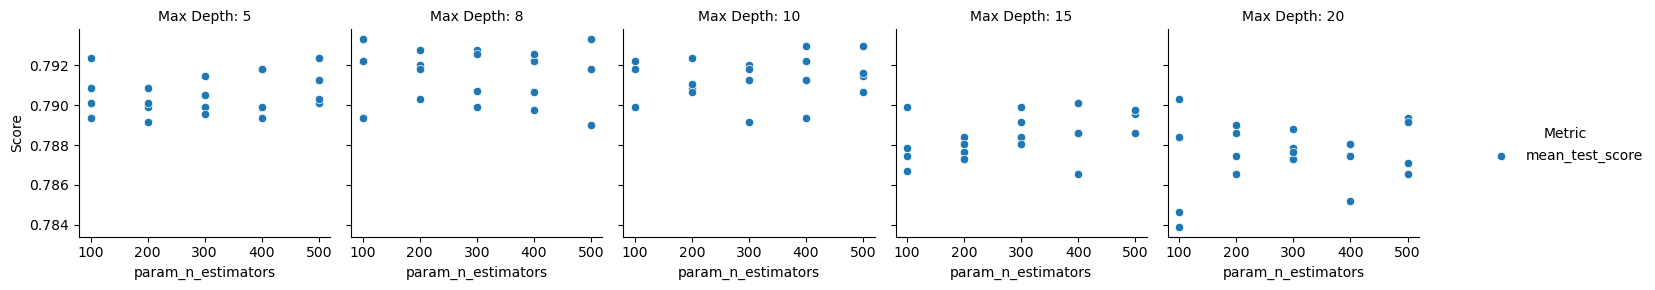

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'random_search' is your already fitted RandomizedSearchCV
results = pd.DataFrame(random_search.cv_results_)

# Select columns of interest
parameters = ['param_n_estimators', 'param_max_depth']
scores = 'mean_test_score'

# Prepare the data
results = results[parameters + [scores]]

# You can uncomment the following line to see the structure of your results
# print(results.head())

# Transform the data for better visualization
results_long = pd.melt(results, id_vars=parameters, value_vars=[scores], var_name='Metric', value_name='Score')

# Create a grid of plots for each combination of max_depth
g = sns.FacetGrid(results_long, col='param_max_depth', hue='Metric', margin_titles=True)
g.map(sns.scatterplot, 'param_n_estimators', 'Score')
g.add_legend()

# Adjust titles
g.set_titles(col_template="Max Depth: {col_name}")

# Show the plot
plt.show()



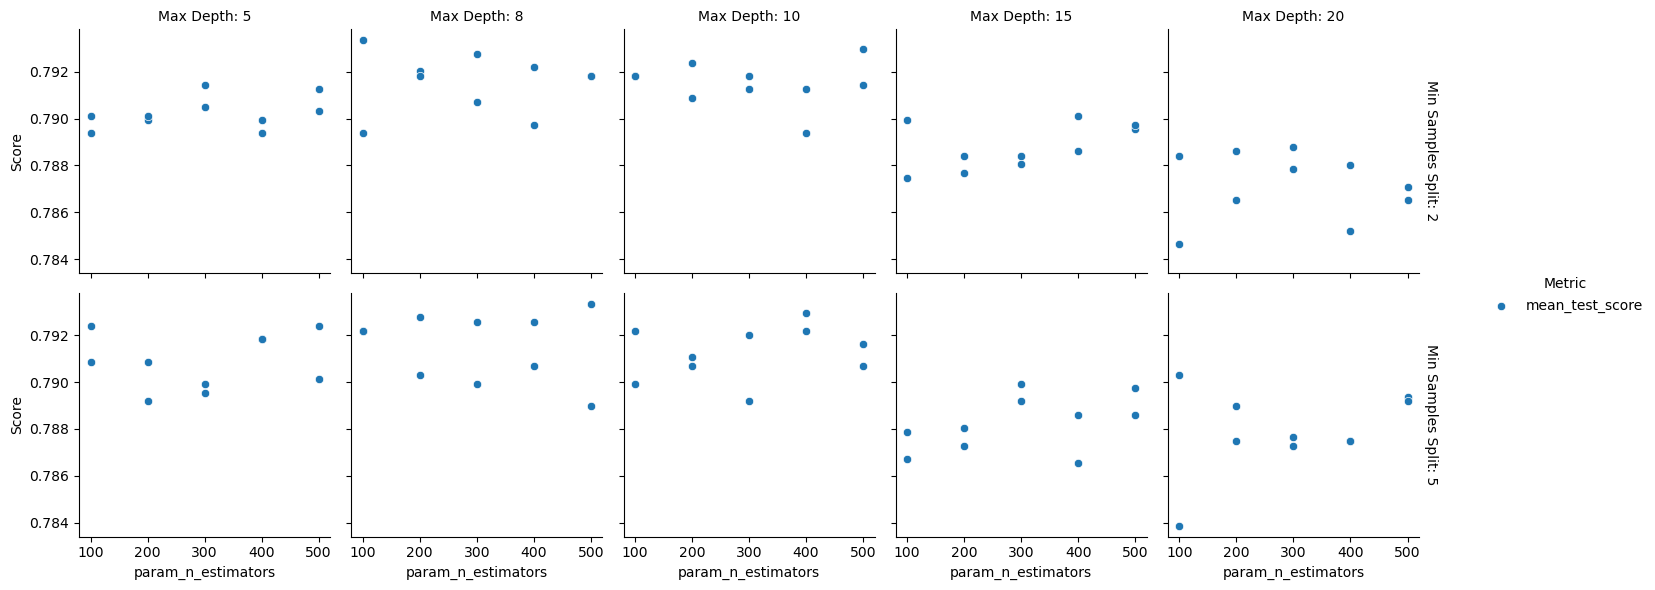

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'random_search' is your already fitted RandomizedSearchCV
results = pd.DataFrame(random_search.cv_results_)

# Select columns of interest
parameters = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_bootstrap']
scores = 'mean_test_score'

# Prepare the data
results = results[parameters + [scores]]

# You can uncomment the following line to see the structure of your results
# print(results.head())

# Transform the data for better visualization
results_long = pd.melt(results, id_vars=parameters, value_vars=[scores], var_name='Metric', value_name='Score')

# Create a grid of plots for each combination of max_depth and min_samples_split
g = sns.FacetGrid(results_long, col='param_max_depth', row='param_min_samples_split', hue='Metric', margin_titles=True)
g.map(sns.scatterplot, 'param_n_estimators', 'Score')
g.add_legend()

# Adjust titles
g.set_titles(col_template="Max Depth: {col_name}", row_template="Min Samples Split: {row_name}")

# Show the plot
plt.show()
